## Fit autocovariance

Objective : Estimate tides paramters by fitting a model to Eulerian and Lagrangian binned covariance of the demodulated velocity field

Several parameters of the fitting method can be testing.
Here we focus on a least-square method.

1) Basic method :

Model : $\tilde V e^{-\tau/\tilde T}cos(\omega\tau)$ ; with $\tilde V$ the variance, $\tilde T$ the incoherence timescale and $\omega = \frac{\omega_{S2}-\omega_{M2}}{2}$ fixed the spring neap cycle frequency over 2 (oscilations caused by demodulation)

No bounds, no first guess for the estimates, same weight at all timelag

2) Bounds imposed

3) More weight on the shortest timelags (20days) and a lot on the first. First guess for $\tilde V$ fixed at the autocovariance at timelag 0

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize
#import mitequinox.sigp as sp

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

from inspect import signature
import scipy

In [2]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2

In [3]:
omega_sn = (omega_S2-omega_M2)/2

print('Spring-neap cycle : ', 1/(2*omega_sn), 'days')
print('Oscillation after demodulation ( spring-neap cycle /2): ', 1/omega_sn, 'days')

Spring-neap cycle :  14.765294045749723 days
Oscillation after demodulation ( spring-neap cycle /2):  29.530588091499446 days


In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,**kwargs):
    cbar_kw = {'fraction':0.02}
    cbar_kw.update(**kwargs)
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat_bin',ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,**kwargs,
           cbar_kwargs=cbar_kw)
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [5]:
#root_path = '/home/datawork-lops-osi/equinox/jetn/'
root_path = '/Users/zcaspar/codes/mit4320/'

#Eulerian
dsE = xr.open_dataset(root_path+'E_hf_fit.nc')
dsE_v2 = xr.open_dataset(root_path+'E_hf_fit_gauss.nc')
#Lagrangian
dsL = xr.open_dataset(root_path+'L_hf_fit.nc')
dsL_v2 = xr.open_dataset(root_path+'L_hf_fit_gauss.nc')

#### Decorrelation timescale

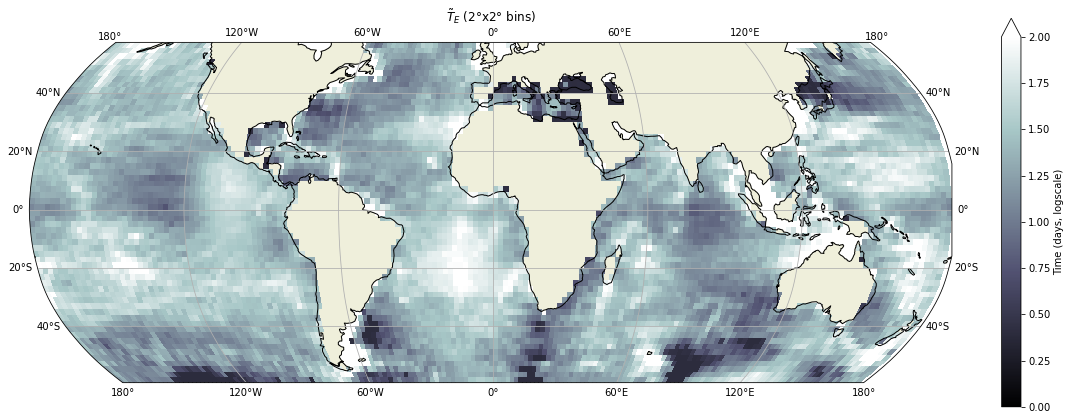

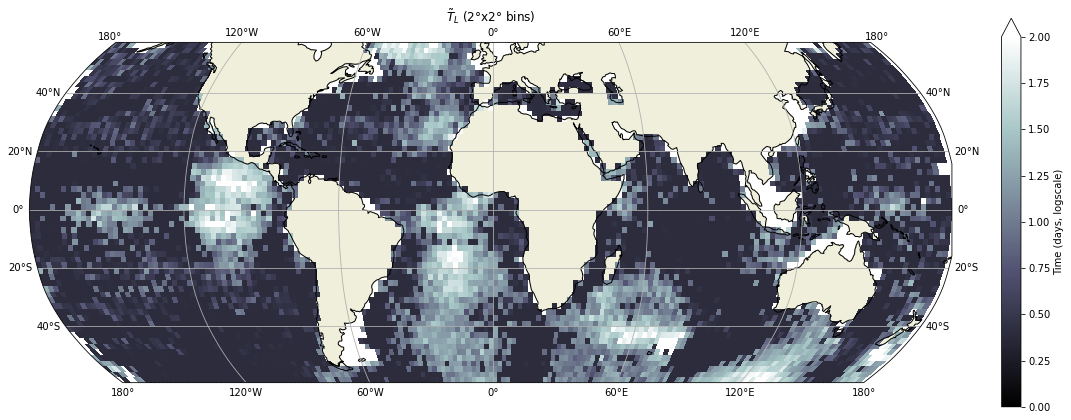

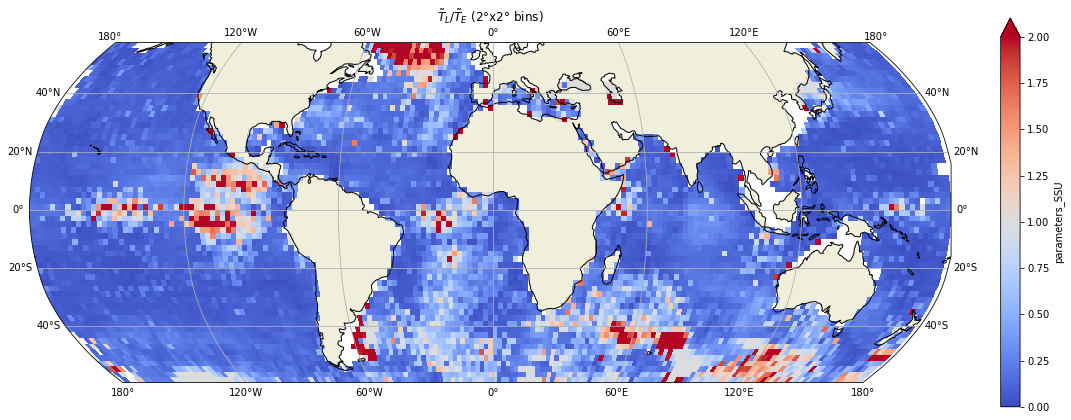

In [6]:
figsize = (15,6)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Ttilde_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Ttilde_log.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL.sel(param = 'T').parameters_SSU/dsE.sel(param = 'T').parameters_SSU,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\tilde{T}_L/\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_Ttilde.png',bbox_inches="tight")

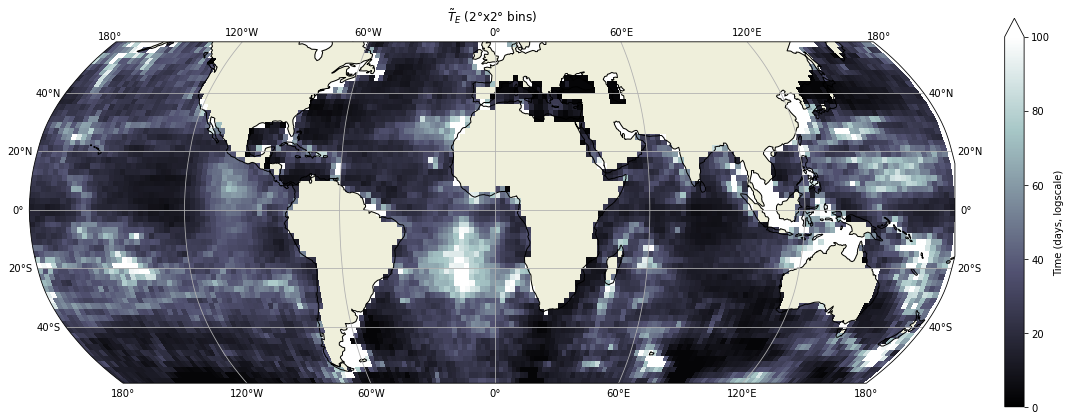

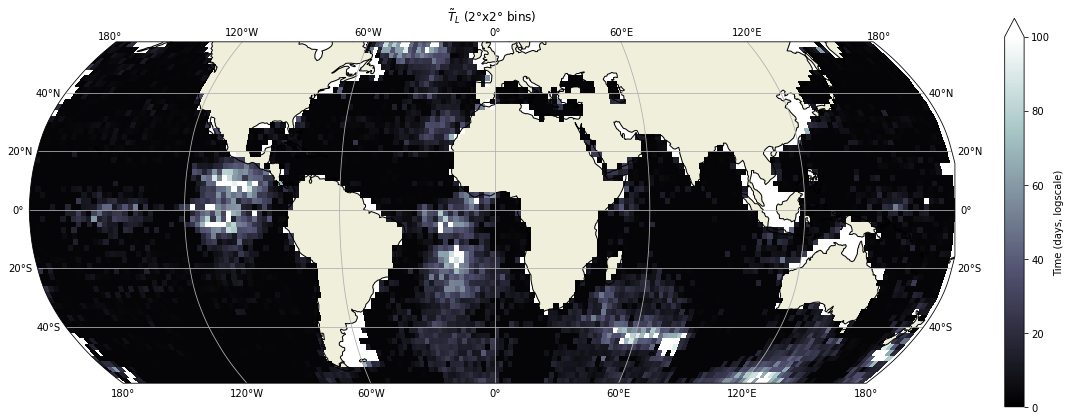

In [16]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,100),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Ttilde.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,100),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Ttilde.png',bbox_inches="tight")

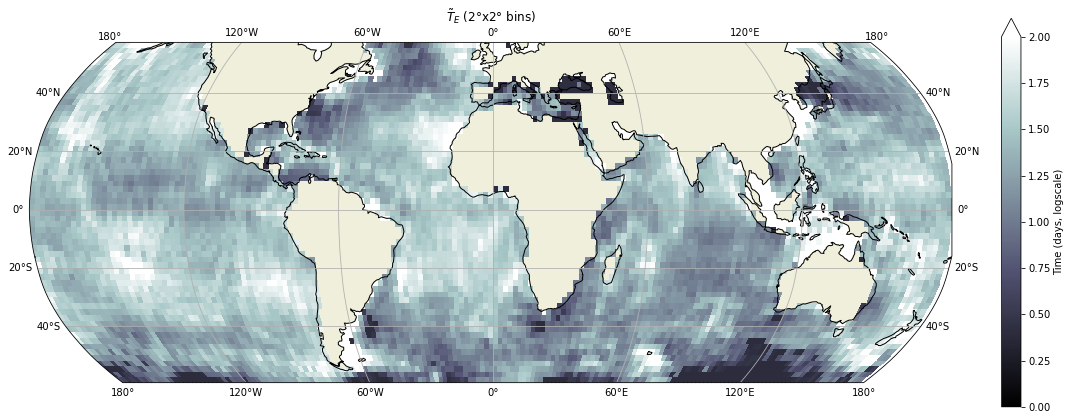

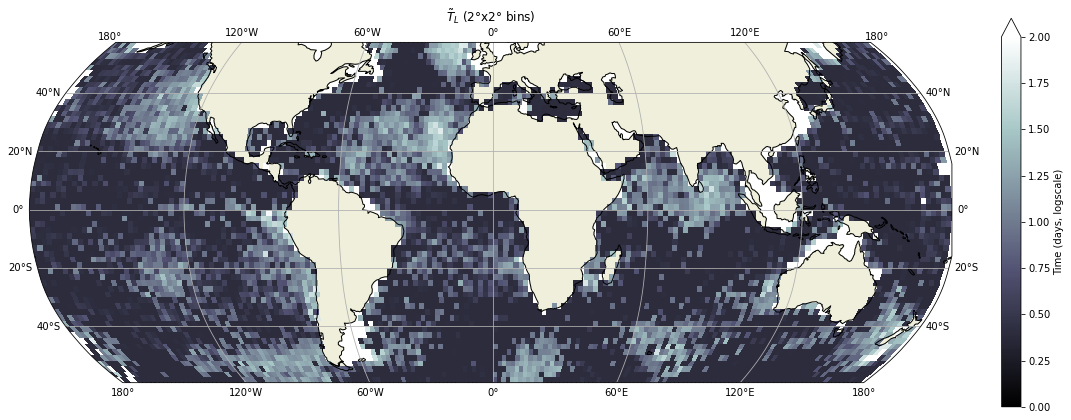

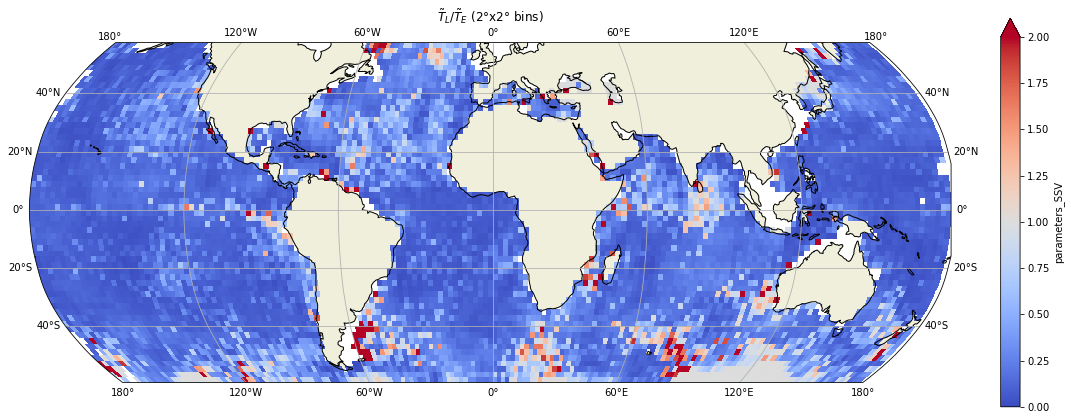

In [17]:
figsize = (15,6)

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_mean1_log.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL.sel(param = 'T').parameters_SSV/dsE.sel(param = 'T').parameters_SSV,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\tilde{T}_L/\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()

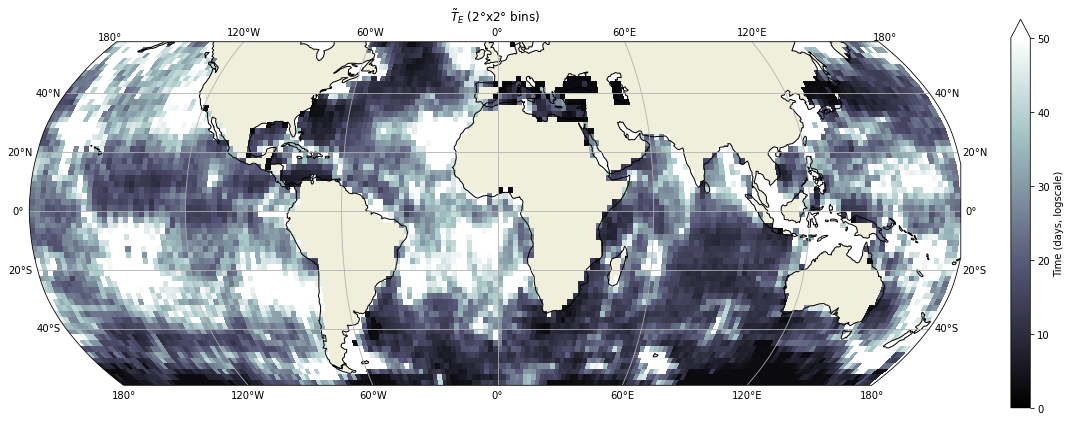

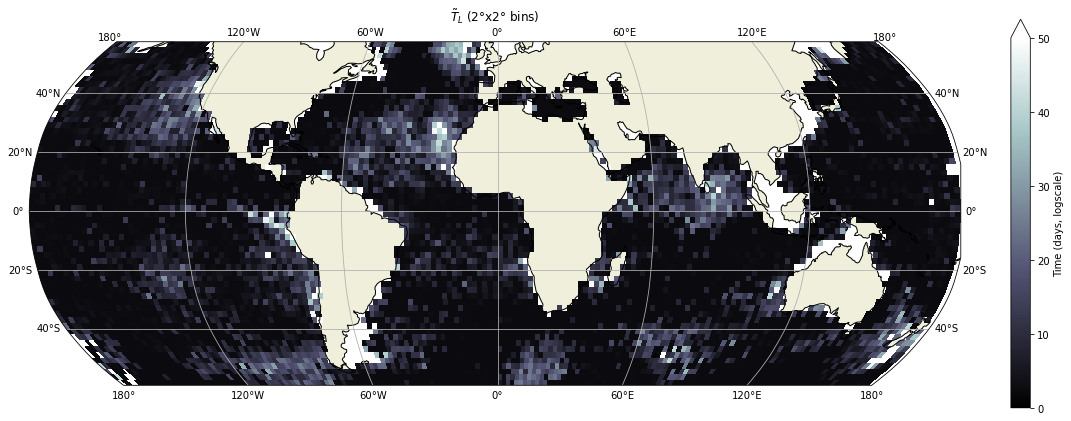

In [18]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,50),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,50),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()

#### Gaussian

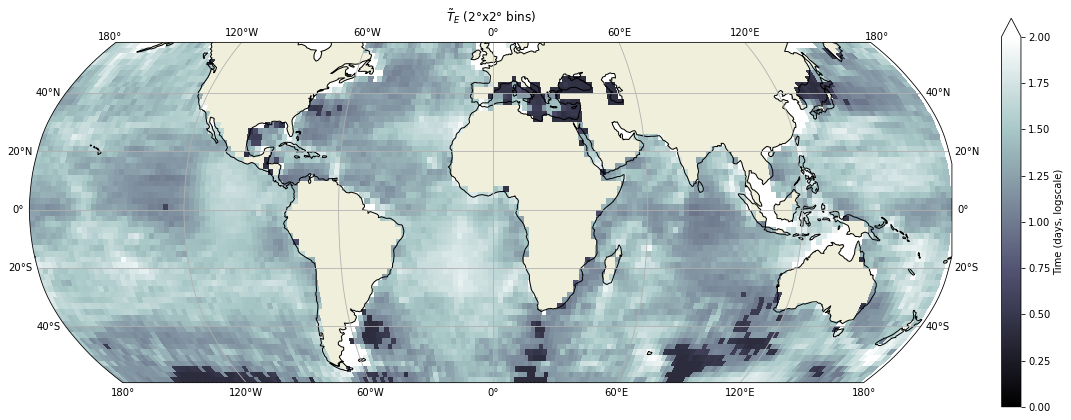

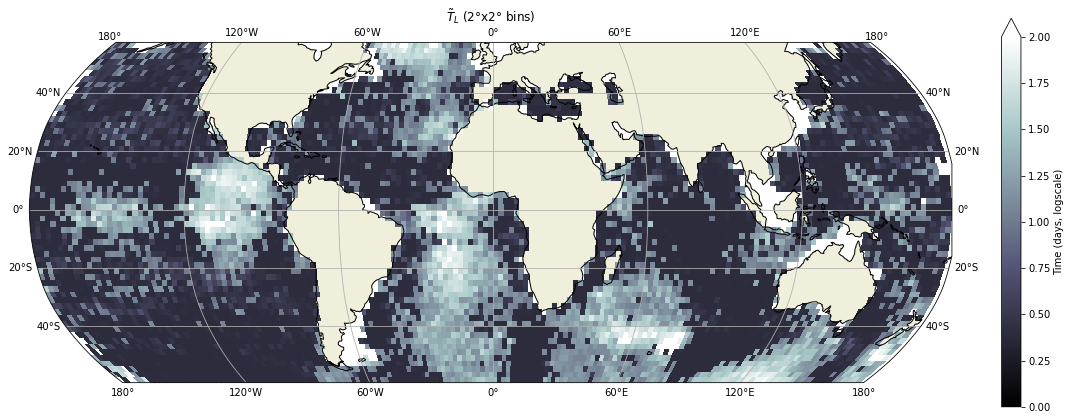

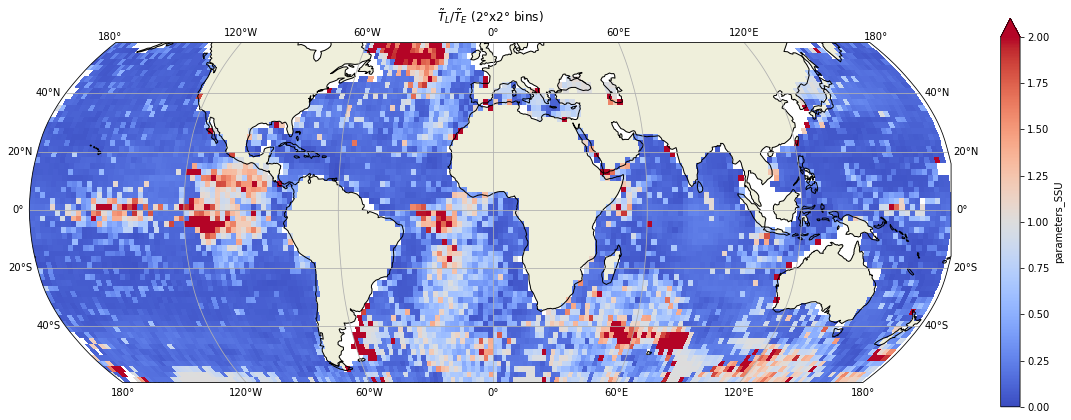

In [19]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE_v2.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Ttilde_log_v2.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL_v2.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Ttilde_log_v2.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_v2.sel(param = 'T').parameters_SSU/dsE_v2.sel(param = 'T').parameters_SSU,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\tilde{T}_L/\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_Ttilde_v2.png',bbox_inches="tight")

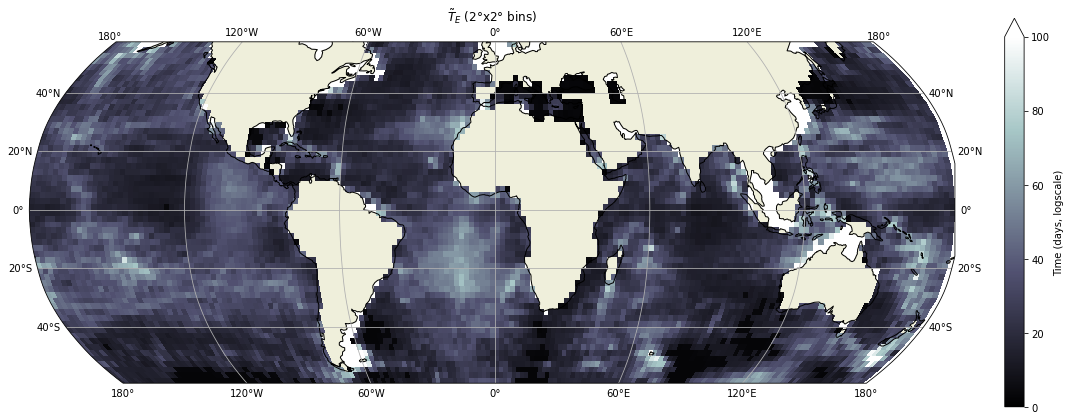

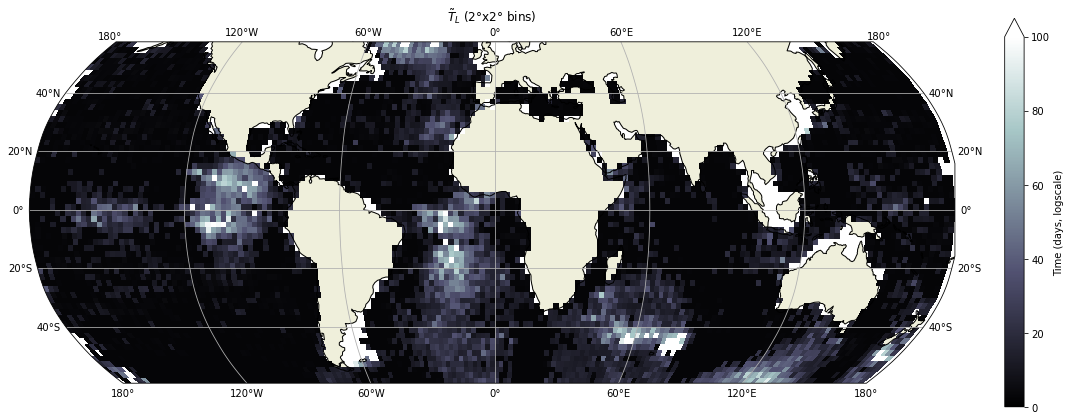

In [20]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_v2.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,100),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Ttilde_v2.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_v2.sel(param = 'T').parameters_SSU),colmap='bone',vlim=(0,100),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Ttilde_v2.png',bbox_inches="tight")

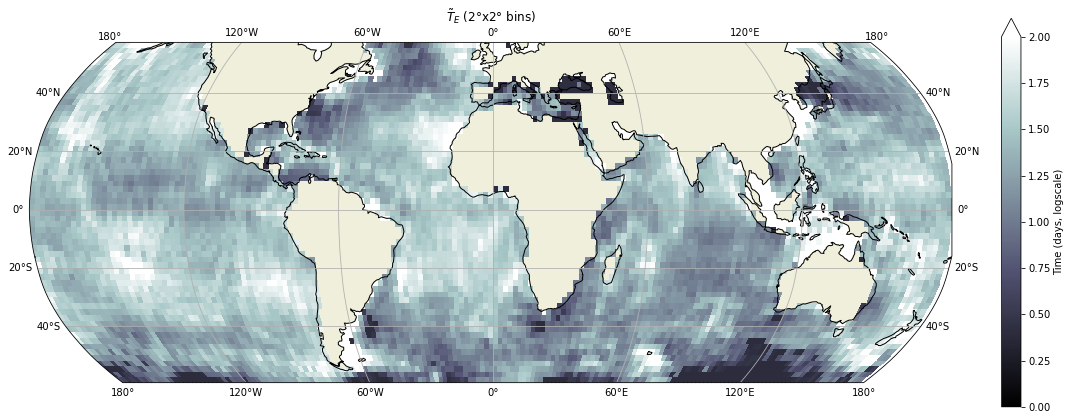

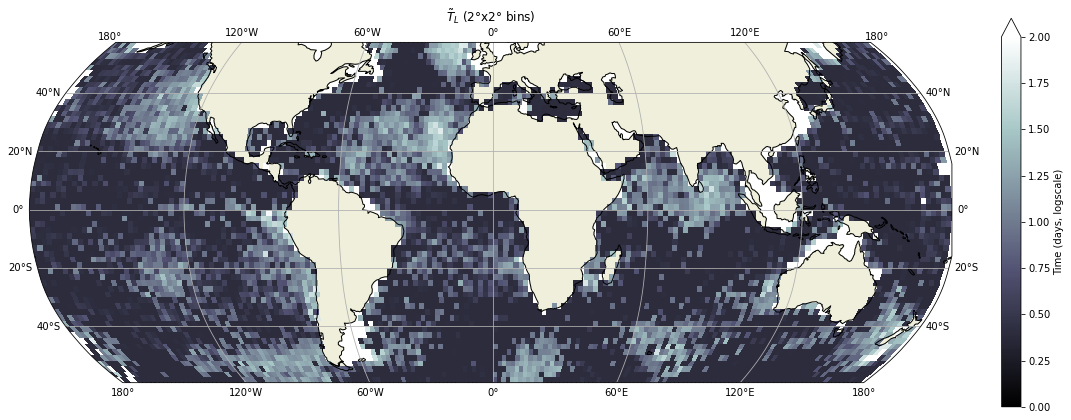

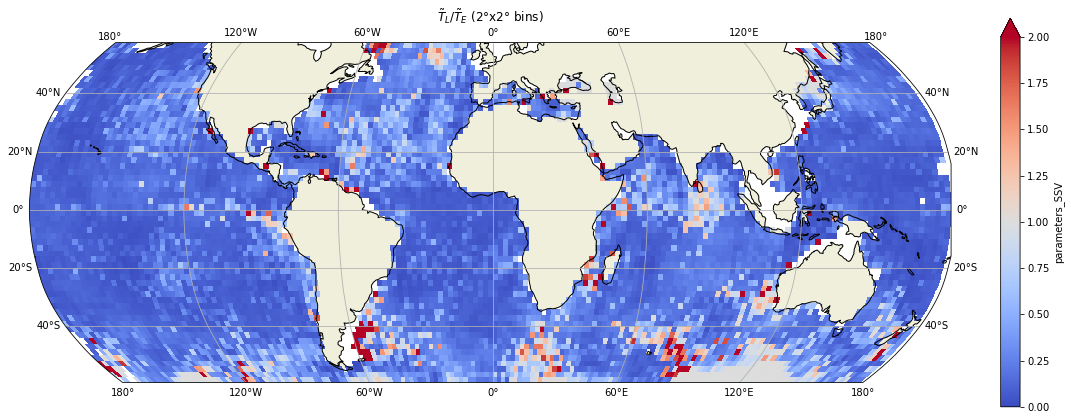

In [21]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsE.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(dsL.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,2),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_mean1_log.png',bbox_inches="tight")

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL.sel(param = 'T').parameters_SSV/dsE.sel(param = 'T').parameters_SSV,
                   colmap='coolwarm',vlim=(0,2))
ax.set_title(r'$\tilde{T}_L/\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()

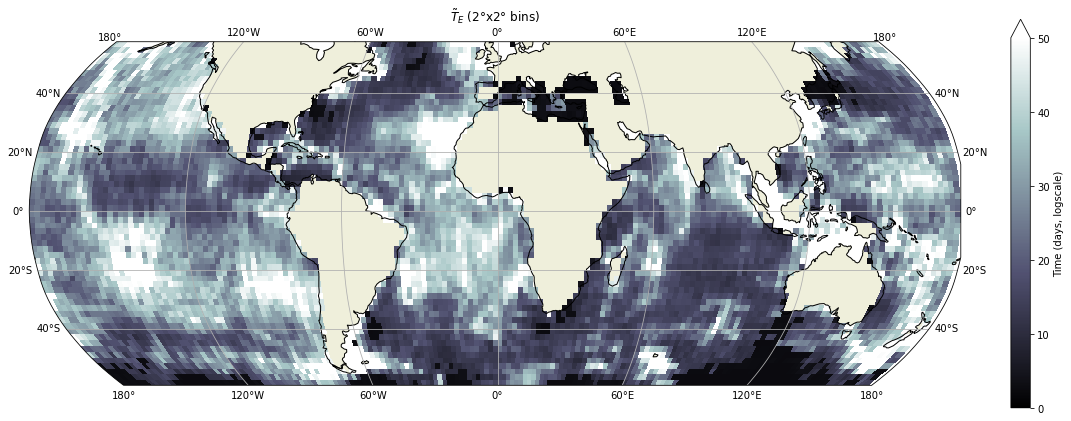

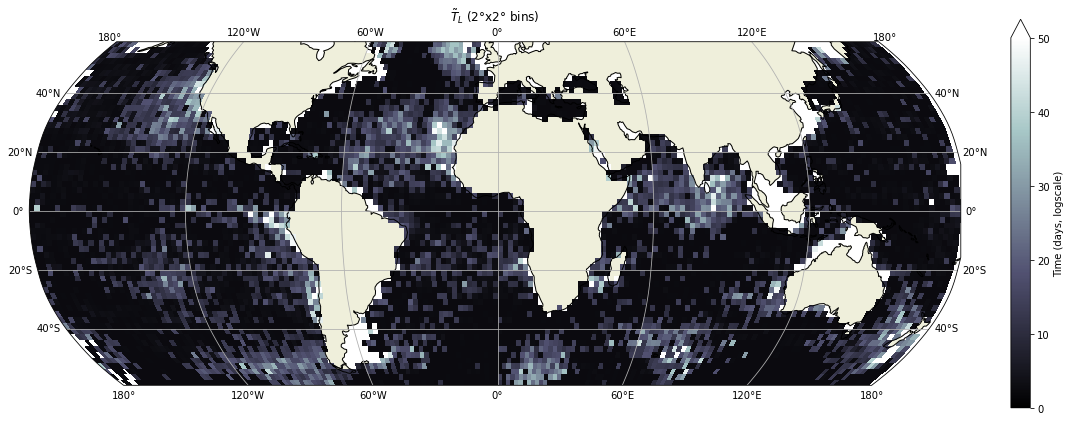

In [22]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsE_v2.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,50),
                   label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_E$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_mean1_log.png',bbox_inches="tight")


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps((dsL_v2.sel(param = 'T').parameters_SSV),colmap='bone',vlim=(0,50),
                  label='Time (days, logscale)')
ax.set_title(r'$\tilde{T}_L$ (2°x2° bins)')
fig.tight_layout()

######

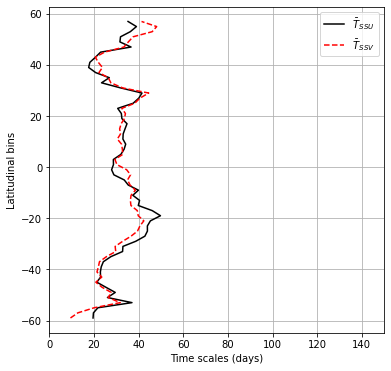

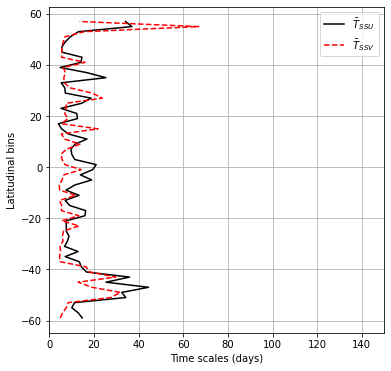

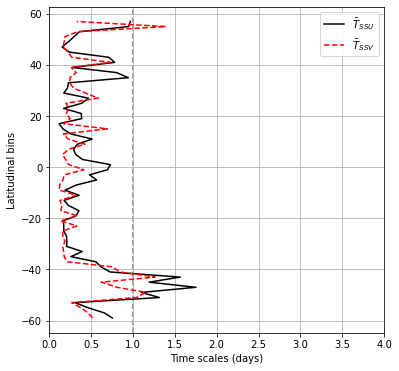

In [17]:
fig,ax = plt.subplots(figsize=(6,6))
dsE.sel(param='T').parameters_SSU.mean('lon_bins').plot(ax=ax,y='lat_bins',label=r'$\bar T_{SSU}$',c='k')
dsE.sel(param='T').parameters_SSV.mean('lon_bins').plot(ax=ax,y='lat_bins',label=r'$\bar T_{SSV}$',
                                                            c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,150)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/E_Tbar_lat_mean1.png',bbox_inches="tight")

fig,ax = plt.subplots(figsize=(6,6))
dsL.sel(param='T').parameters_SSU.mean('lon_bins').plot(ax=ax,y='lat_bins',label=r'$\bar T_{SSU}$',c='k')
dsL.sel(param='T').parameters_SSV.mean('lon_bins').plot(ax=ax,y='lat_bins',label=r'$\bar T_{SSV}$',
                                                           c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,150)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_Tbar_lat_mean1.png',bbox_inches="tight")

fig,ax = plt.subplots(figsize=(6,6))
(dsL.sel(param='T').parameters_SSU.mean('lon_bins')/dsE.sel(param='T').parameters_SSU.mean('lon_bins')
).plot(ax=ax,y='lat_bins',label=r'$\bar T_{SSU}$',c='k')
(dsL.sel(param='T').parameters_SSV.mean('lon_bins')/dsE.sel(param='T').parameters_SSV.mean('lon_bins')
).plot(ax=ax,y='lat_bins',label=r'$\bar T_{SSV}$',
                                                           c='r',linestyle='--')
ax.grid();ax.set_ylabel('Latitudinal bins'); ax.set_xlabel('Time scales (days)');
ax.set_title('');ax.legend();ax.set_xlim(0,4);ax.axvline(1,c='grey',linestyle='--',zorder=-1)
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/LE_Tbar_lat_mean1.png',bbox_inches="tight")


#### Energy loss in Lagrangian

In [7]:
ds_low = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_binned_dl2.0.nc'),
                   xr.open_dataset(root_path+'energy_SSV_low_binned_dl2.0.nc')])
ds_low_var = xr.merge([xr.open_dataset(root_path+'energy_SSU_low_variance_binned_dl2.0.nc'),
                      xr.open_dataset(root_path+'energy_SSV_low_variance_binned_dl2.0.nc')])


In [11]:
#Eulerian
dsE_low_mean0_v1 = xr.open_dataset(root_path+'E_low_fit_mean0_v1.nc')
dsE_low_mean0 = xr.open_dataset(root_path+'E_low_fit_mean0_v2.nc')
dsE_low_mean1 = xr.open_dataset(root_path+'E_low_fit_mean1.nc')

#Lagrangian
dsL_low_mean0_v1 = xr.open_dataset(root_path+'L_low_fit_mean0_v1.nc')
dsL_low_mean0 = xr.open_dataset(root_path+'L_low_fit_mean0_v2.nc')
dsL_low_mean1 = xr.open_dataset(root_path+'L_low_fit_mean1.nc')

In [9]:
rad = 2*np.pi
k = rad/(100*1e3)
day2sec = 3600*24

In [12]:
Uebar = np.sqrt(ds_low.E_energy_SSU)
Ulbar = np.sqrt(ds_low.L_energy_SSU)
Vebar = np.sqrt(ds_low.E_energy_SSV)
Vlbar = np.sqrt(ds_low.L_energy_SSV)

Uebar_bis = np.sqrt(ds_low_var.E_energy_SSU)
Ulbar_bis = np.sqrt(ds_low_var.L_energy_SSU)
Vebar_bis = np.sqrt(ds_low_var.E_energy_SSV)
Vlbar_bis = np.sqrt(ds_low_var.L_energy_SSV)

Tebar_mean0 = dsE_low_mean0.sel(param='T').parameters_SSU
Tlbar_mean0 = dsL_low_mean0.sel(param='T').parameters_SSU

Tebar_mean1 = dsE_low_mean1.sel(param='T').parameters_SSU
Tlbar_mean1 = dsL_low_mean1.sel(param='T').parameters_SSU

Tebar_mean0_V = dsE_low_mean0.sel(param='T').parameters_SSV
Tlbar_mean0_V = dsL_low_mean0.sel(param='T').parameters_SSV

Tebar_mean1_V = dsE_low_mean1.sel(param='T').parameters_SSV
Tlbar_mean1_V = dsL_low_mean1.sel(param='T').parameters_SSV

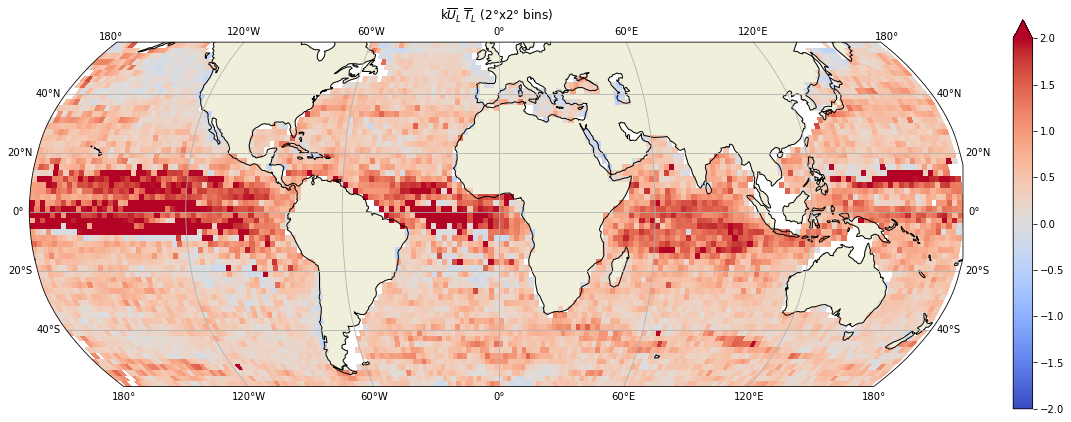

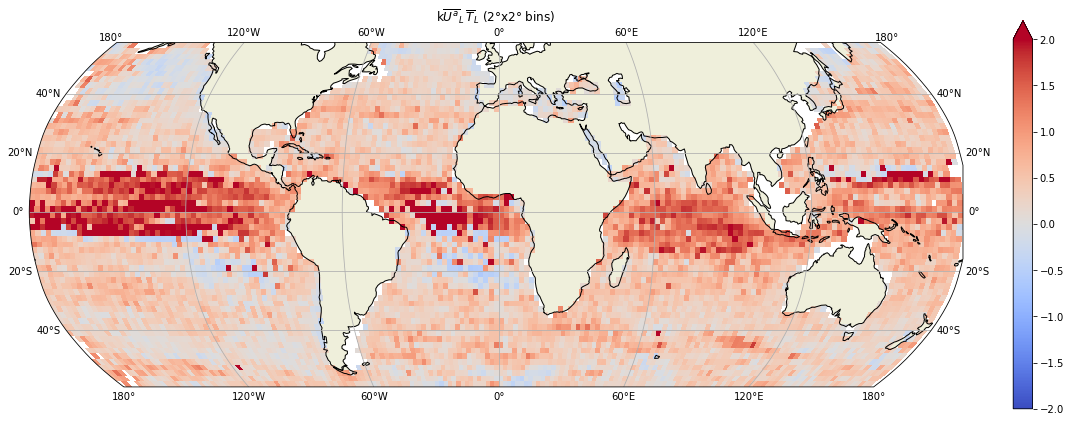

In [17]:
figsize=(15,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar*Tlbar_mean0*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean0.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar_bis*Tlbar_mean0*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')




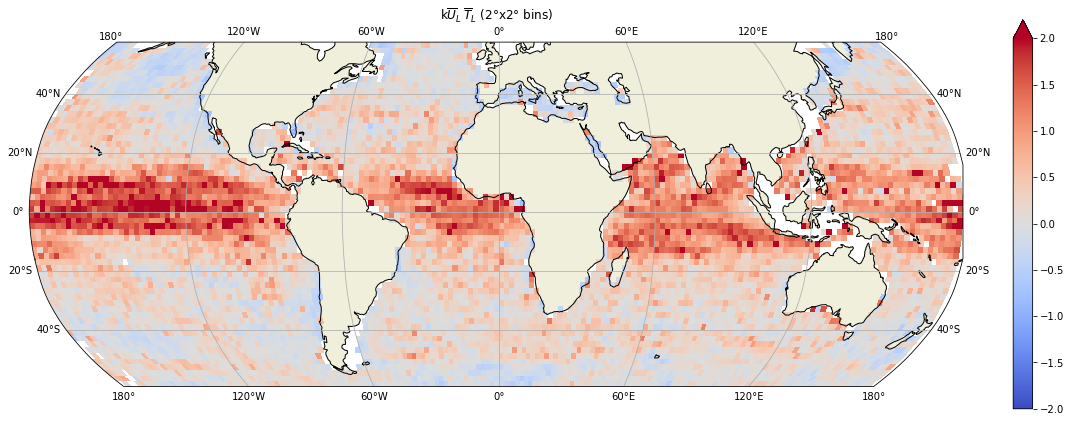

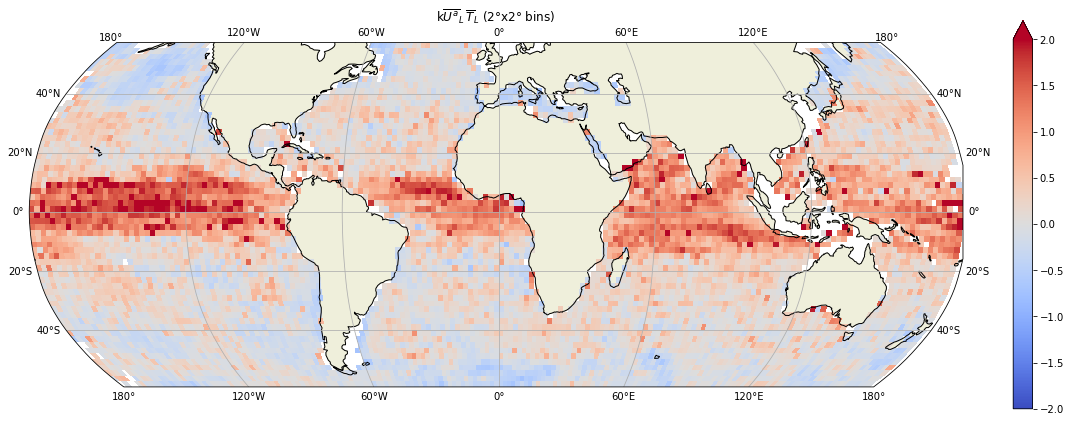

In [32]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar*Tlbar_mean1*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Ulbar_bis*Tlbar_mean1*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')

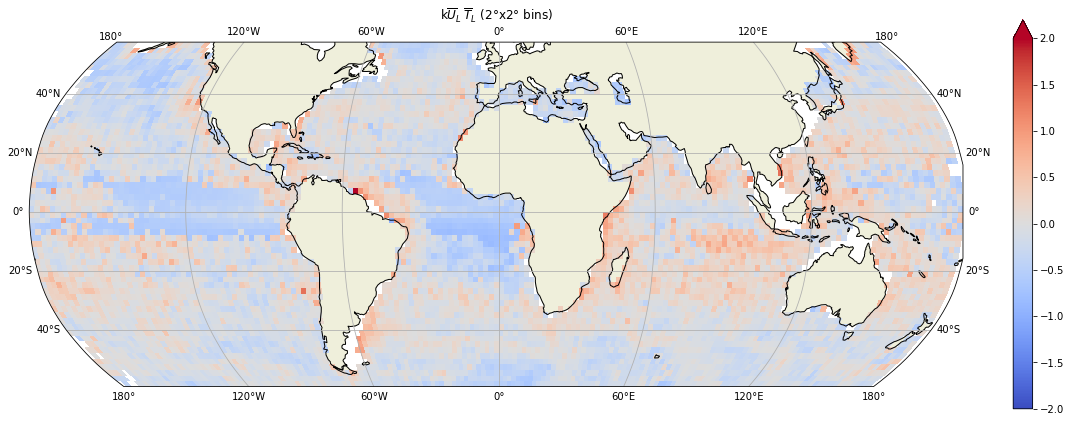

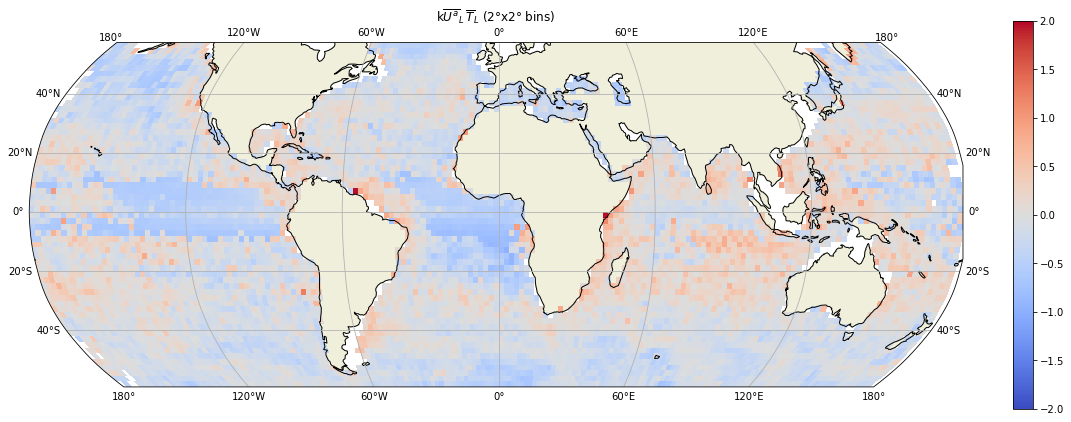

In [34]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar*Tlbar_mean0_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kVT_mean0.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar_bis*Tlbar_mean0_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')



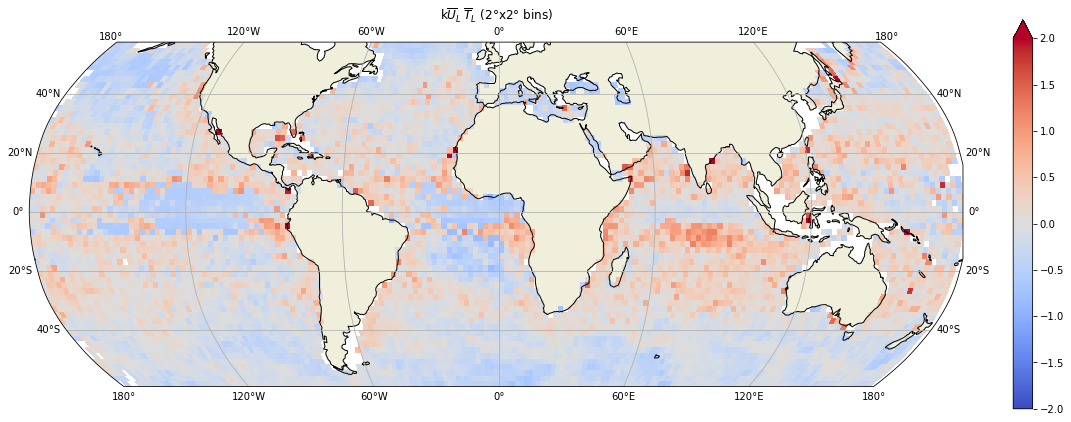

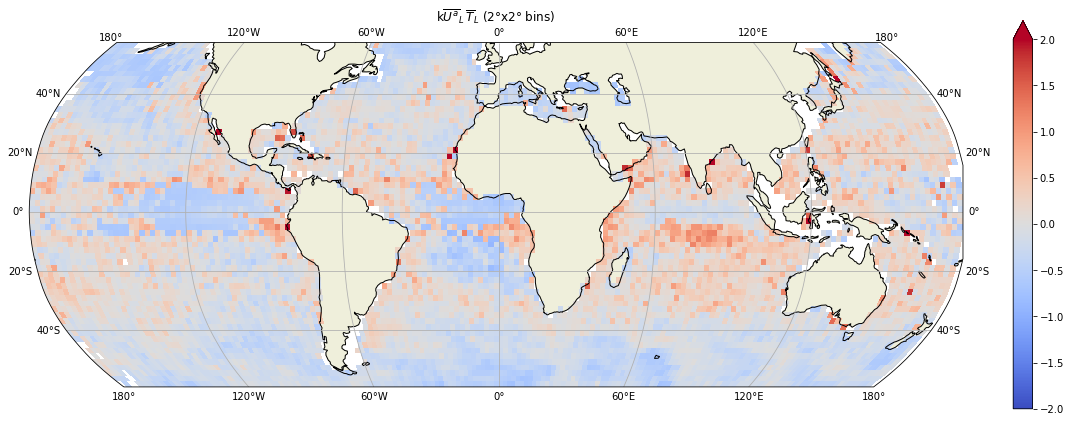

In [35]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar*Tlbar_mean1_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kVT_mean1.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(np.log10(k*Vlbar_bis*Tlbar_mean1_V*day2sec),colmap='coolwarm',vlim=(-2,2))
ax.set_title(r'k$\overline{U^a}_L \: \overline{T}_L$ (2°x2° bins)')
fig.tight_layout()
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/L_kUT_mean1.png',bbox_inches='tight')




In [25]:
contamination = lambda ds : 4*ds['domega']/(np.pi*ds['omega']**2*ds['T'])

In [26]:
Tl = dsL_low_mean0.sel(param='T').parameters_SSU
Tlv = dsL_low_mean0.sel(param='T').parameters_SSV
Ul = ds_low.L_energy_SSU
Vl = ds_low.L_energy_SSV

Te = dsE_low_mean0.sel(param='T').parameters_SSU
Tev = dsE_low_mean0.sel(param='T').parameters_SSV
Ue = ds_low.E_energy_SSU
Ve = ds_low.E_energy_SSV

domega = 0.2
_omega = omega

In [27]:
dsL_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Tl})
dsLV_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Tlv})

dsE_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Te})
dsEV_contamination = xr.Dataset({'omega':_omega,'domega':domega,'T':Tev})

In [28]:
_dsL = contamination(dsL_contamination)
_dsLV = contamination(dsLV_contamination)

_dsE = contamination(dsE_contamination)
_dsEV = contamination(dsEV_contamination)


Text(0.5, 1.0, '$4d\\omega/(\\pi\\omega^2\\bar T_L)$ (2°x2° bins)')

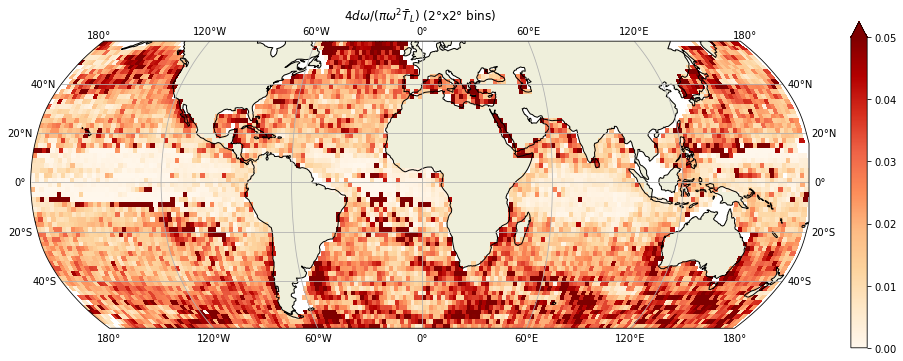

In [40]:
cmap='OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_ds,vlim=(0,0.05),colmap=cmap)
ax.set_title(r'$4d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_mean1.png')

Text(0.5, 1.0, '$4d\\omega/(\\pi\\omega^2\\bar T_L)$ (2°x2° bins)')

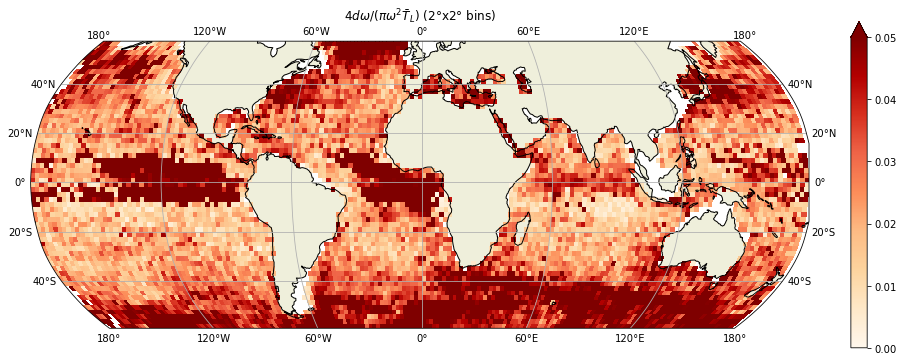

In [41]:
cmap='OrRd'
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_dsV,vlim=(0,0.05),colmap=cmap)
ax.set_title(r'$4d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
#fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_SSV_mean1.png')

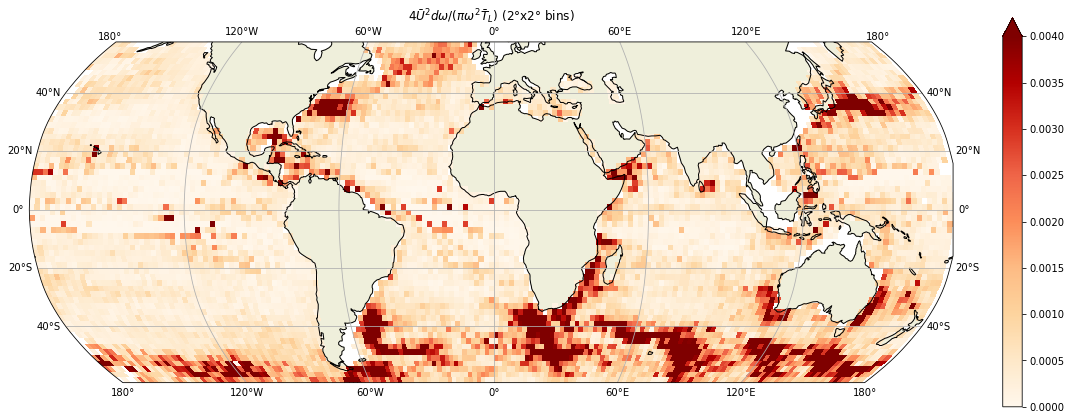

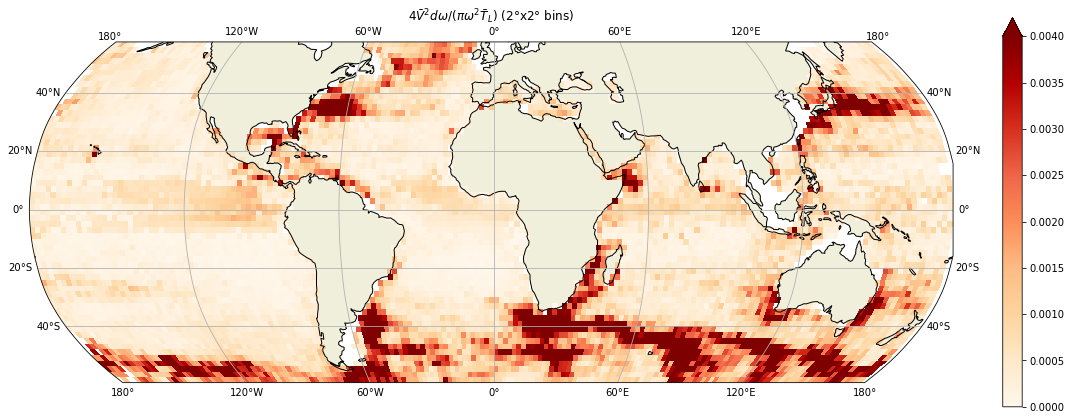

In [47]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_ds*U,vlim=(0,0.004),colmap=cmap)
ax.set_title(r'$4\bar U^2d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_mean0.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_dsV*V,vlim=(0,0.004),colmap=cmap)
ax.set_title(r'$4\bar V^2d\omega/(\pi\omega^2\bar T_L)$ (2°x2° bins)')
fig.tight_layout()
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lf_contamination_SSV_mean0.png',bbox_inches='tight')

Text(0.5, 1.0, '$4d\\omega\\tilde U/(\\pi\\omega^2\\bar T_L)$ (2°x2° bins)')

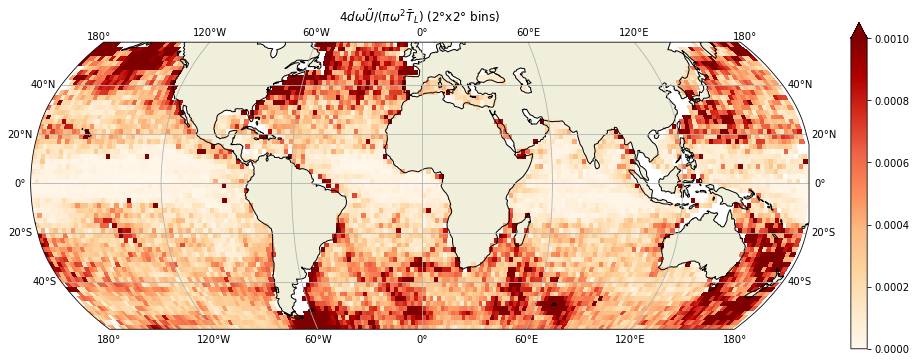

In [70]:
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(_ds*np.sqrt(hf_dl2.L_energy_SSU),vlim=(0,0.001),colmap=cmap)
ax.set_title(r'$4d\omega\tilde U/(\pi\omega^2\bar T_L)$ (2°x2° bins)')

#### Test cells

In [6]:
#Eulerian
dsE_low_mean0 = xr.open_dataset(root_path+'E_low_fit_mean0_v2.nc'
                               ).rename({'lon_bin':'lon_bins','lat_bin':'lat_bins'})
dsE_low_mean1 = xr.open_dataset(root_path+'E_low_fit_mean1.nc')

#Lagrangian
dsL_low_mean0 = xr.open_dataset(root_path+'L_low_fit_mean0_v2.nc'
                                ).rename({'lon_bin':'lon_bins','lat_bin':'lat_bins'})
dsL_low_mean1 = xr.open_dataset(root_path+'L_low_fit_mean1.nc')

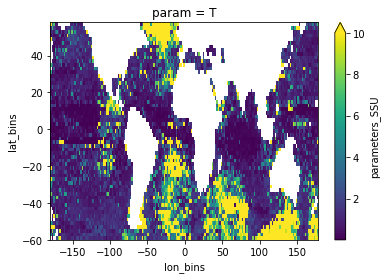

In [7]:
(dsL_v2.sel(param='T').parameters_SSU/dsL_low_mean0.sel(param='T').parameters_SSU).plot(vmax=10)

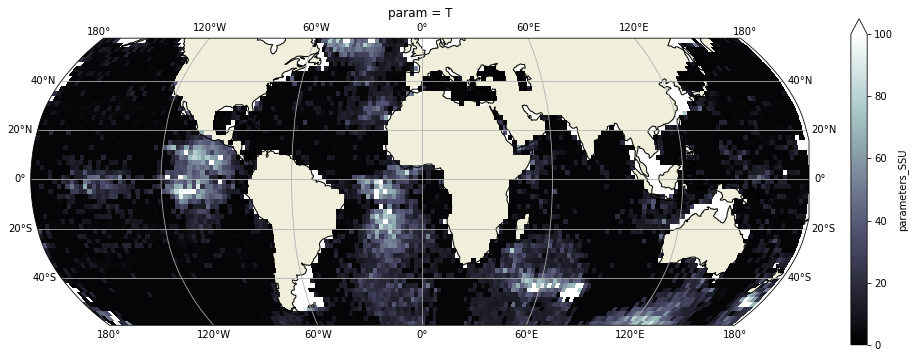

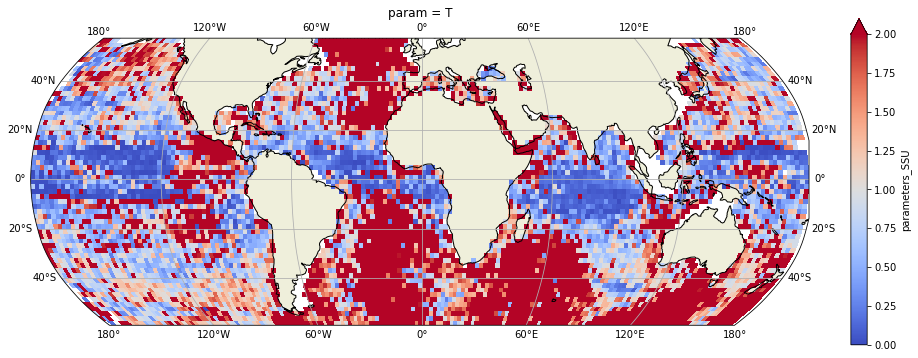

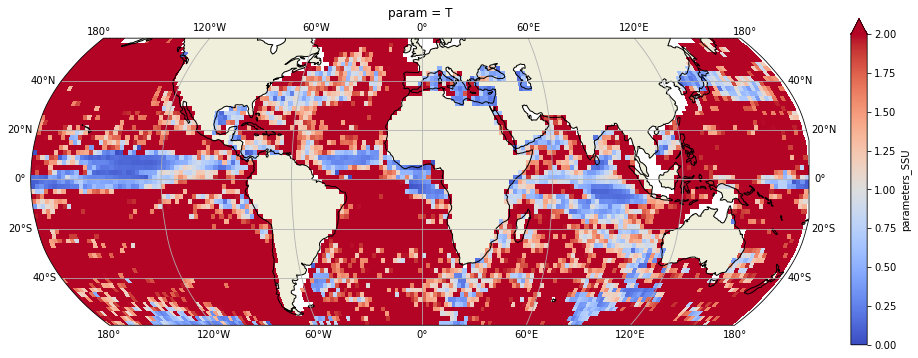

In [8]:
figsize=(15,6)
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_v2.sel(param='T').parameters_SSU
                   ,vlim=(0,100),colmap='bone')
fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsL_v2.sel(param='T').parameters_SSU/dsL_low_mean0.sel(param='T').parameters_SSU
                   ,vlim=(0,2),colmap='coolwarm')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(dsE_v2.sel(param='T').parameters_SSU/dsE_low_mean0.sel(param='T').parameters_SSU
                   ,vlim=(0,2),colmap='coolwarm')

In [9]:
SSUV = xr.open_zarr(root_path+'SSUV_T60_lat_lon_2deg.zarr').compute()
SSUV = SSUV.rename({'lon':'lon_bins','lat':'lat_bins'})

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_2130/4218980994.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  SSUV = xr.open_zarr(root_path+'SSUV_T60_lat_lon_2deg.zarr').compute()


In [10]:
L_SSUV = xr.open_zarr(root_path+'spectra_uv_T60_mean0_lat_lon_2deg.zarr').compute()
L_SSUV = L_SSUV.rename({'frequency':'freq_time'})

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_2130/1200184030.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  L_SSUV = xr.open_zarr(root_path+'spectra_uv_T60_mean0_lat_lon_2deg.zarr').compute()


In [11]:
SSUV = xr.merge([SSUV,L_SSUV.rename({'E':'L_SSUV'})])

In [12]:
SSUV = SSUV.where(SSUV.E_SSUV.sel(freq_time=2)>0)

In [13]:
Tl = dsL_v2.sel(param='T').parameters_SSU
#dsL_v2.where(dsl_v2;sel(para))

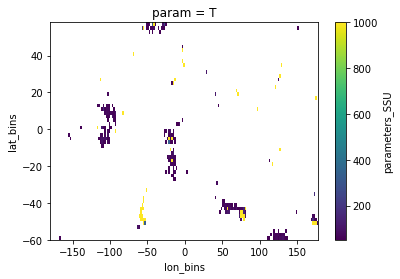

In [14]:
Tl.where(Tl>50).plot()

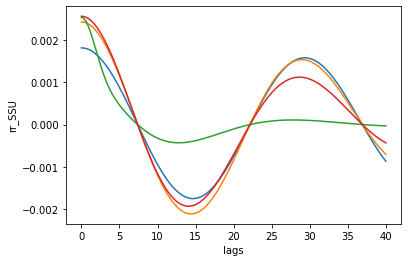

In [15]:
dsL_v2.where(Tl>50).rr_SSU.mean(['lon_bins','lat_bins']).plot()
dsE_v2.where(Tl>50).rr_SSU.mean(['lon_bins','lat_bins']).plot()

dsL_v2.where(Tl<50).rr_SSU.mean(['lon_bins','lat_bins']).plot()
dsE_v2.where(Tl<50).rr_SSU.mean(['lon_bins','lat_bins']).plot()

In [16]:
omega

1.9661368071336223

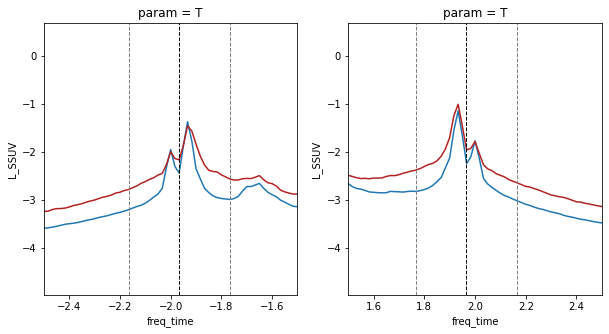

In [17]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
np.log10(SSUV.E_SSUV.where(Tl>50).mean(['lon_bins','lat_bins'])).plot(ax=ax)
np.log10(SSUV.L_SSUV.where(Tl>50).mean(['lon_bins','lat_bins'])).plot(ax=ax,c='firebrick')
ax.set_xlim(-2.5,-1.5);ax.axvline(-omega,c='k',linewidth=1,linestyle='--')
ax.axvline(-omega-0.2,c='grey',linewidth=1,linestyle='--');ax.axvline(-omega+0.2,c='grey',linewidth=1,linestyle='--')

ax = axs[1]
np.log10(SSUV.E_SSUV.where(Tl>50).mean(['lon_bins','lat_bins'])).plot(ax=ax)
np.log10(SSUV.L_SSUV.where(Tl>50).mean(['lon_bins','lat_bins'])).plot(ax=ax,c='firebrick')
ax.set_xlim(1.5,2.5);ax.axvline(omega,c='k',linewidth=1,linestyle='--')
ax.axvline(omega-0.2,c='grey',linewidth=1,linestyle='--');ax.axvline(omega+0.2,c='grey',linewidth=1,linestyle='--')

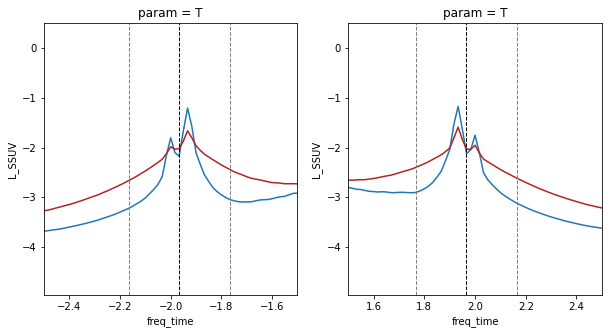

In [18]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
np.log10(SSUV.E_SSUV.where(Tl<50).mean(['lon_bins','lat_bins'])).plot(ax=ax)
np.log10(SSUV.L_SSUV.where(Tl<50).mean(['lon_bins','lat_bins'])).plot(ax=ax,c='firebrick')
ax.set_xlim(-2.5,-1.5);ax.axvline(-omega,c='k',linewidth=1,linestyle='--')
ax.axvline(-omega-0.2,c='grey',linewidth=1,linestyle='--');ax.axvline(-omega+0.2,c='grey',linewidth=1,linestyle='--')

ax = axs[1]
np.log10(SSUV.E_SSUV.where(Tl<50).mean(['lon_bins','lat_bins'])).plot(ax=ax)
np.log10(SSUV.L_SSUV.where(Tl<50).mean(['lon_bins','lat_bins'])).plot(ax=ax,c='firebrick')
ax.set_xlim(1.5,2.5);ax.axvline(omega,c='k',linewidth=1,linestyle='--')
ax.axvline(omega-0.2,c='grey',linewidth=1,linestyle='--');ax.axvline(omega+0.2,c='grey',linewidth=1,linestyle='--')

In [29]:
L_M2 = (SSUV.L_SSUV.sel(freq_time=omega_M2,method='nearest')+SSUV.L_SSUV.sel(freq_time=-omega_M2,method='nearest'))
E_M2 = (SSUV.E_SSUV.sel(freq_time=omega_M2,method='nearest')+SSUV.E_SSUV.sel(freq_time=-omega_M2,method='nearest'))

L_S2 = (SSUV.L_SSUV.sel(freq_time=2)+SSUV.L_SSUV.sel(freq_time=-2))
E_S2 = (SSUV.E_SSUV.sel(freq_time=2)+SSUV.E_SSUV.sel(freq_time=-2))

In [33]:
L_sd = (SSUV.L_SSUV.sel(freq_time=omega,method='nearest')+SSUV.L_SSUV.sel(freq_time=-omega,method='nearest'))
E_sd = (SSUV.E_SSUV.sel(freq_time=omega,method='nearest')+SSUV.E_SSUV.sel(freq_time=-omega,method='nearest'))



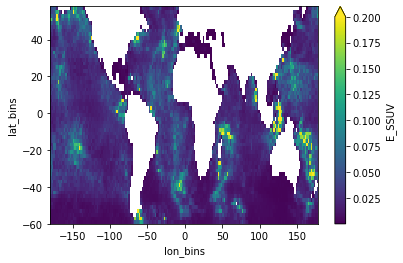

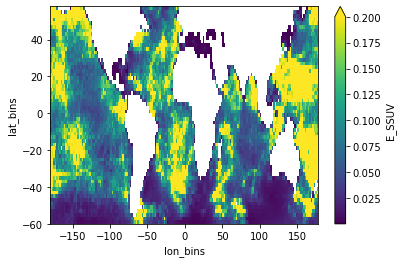

In [30]:
E_S2.plot(y='lat_bins',vmax=0.2)
plt.figure()
E_M2.plot(y='lat_bins',vmax=0.2)

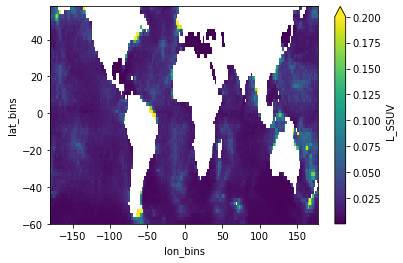

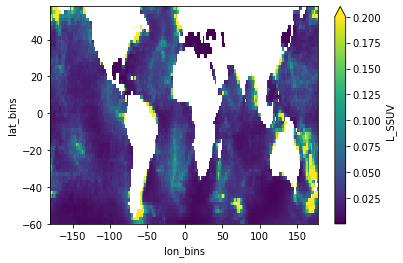

In [31]:
L_S2.plot(y='lat_bins',vmax=0.2)
plt.figure()
L_M2.plot(y='lat_bins',vmax=0.2)

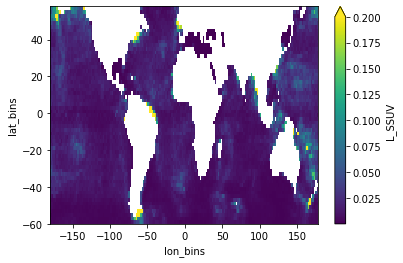

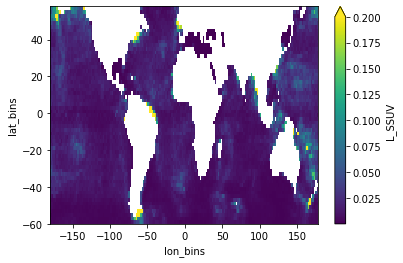

In [34]:
L_sd.plot(y='lat_bins',vmax=0.2)
plt.figure()
L_sd.plot(y='lat_bins',vmax=0.2)

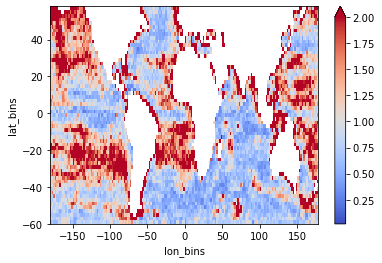

In [37]:
(L_sd/E_sd).plot(y='lat_bins',vmax=2,cmap='coolwarm')



#### Zoom

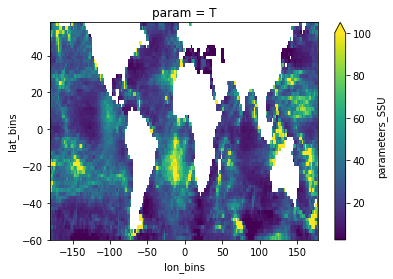

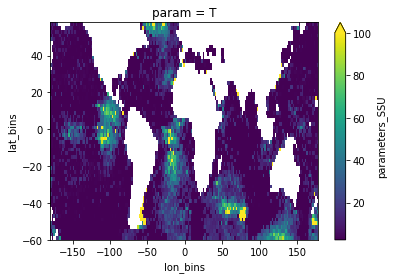

In [9]:
(dsE.sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')
plt.figure()
(dsL_v2.sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')

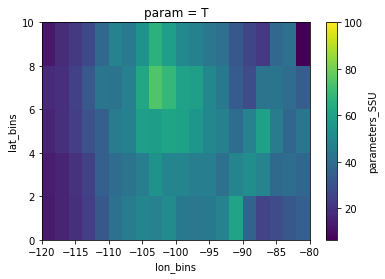

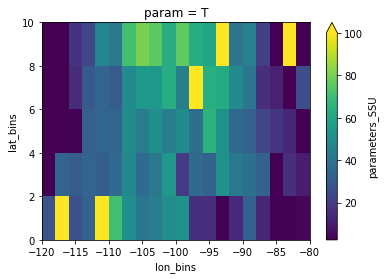

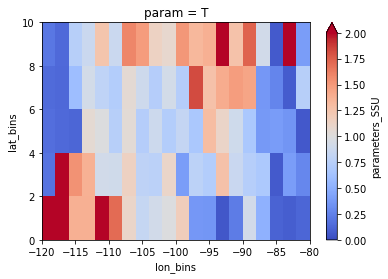

In [21]:
lat0,lat1 = 0,10
lon0,lon1 = -120,-80

(dsE.sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')
plt.figure()
(dsL_v2.sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')
plt.figure()
(dsL_v2/dsE).sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU.plot(y='lat_bins',vmax=2,vmin=0,cmap='coolwarm')

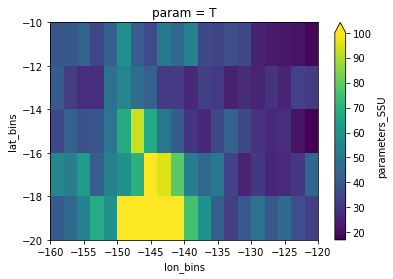

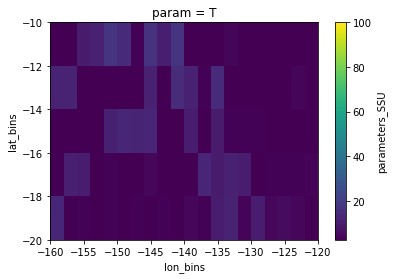

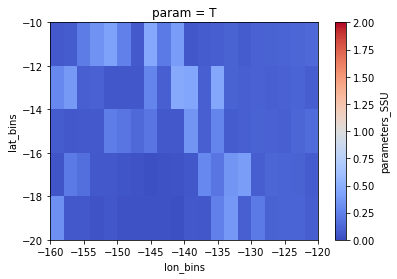

In [20]:
lat0,lat1 = -20,-10
lon0,lon1 = -160,-120

(dsE.sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')
plt.figure()
(dsL_v2.sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')
plt.figure()
(dsL_v2/dsE).sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU.plot(y='lat_bins',vmax=2,vmin=0,cmap='coolwarm')

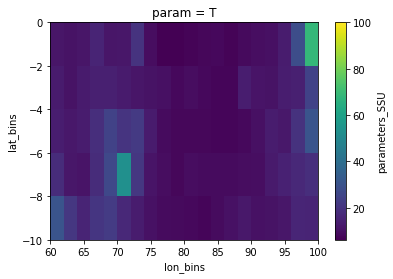

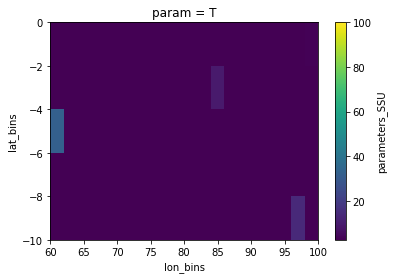

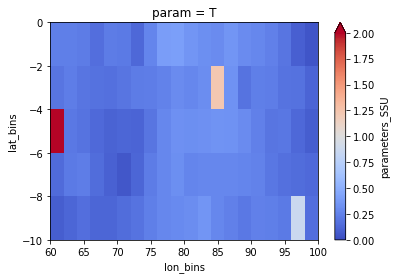

In [22]:
lat0,lat1 = -10,0
lon0,lon1 = 60,100

(dsE.sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')
plt.figure()
(dsL_v2.sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)

           ).sel(param = 'T').parameters_SSU).plot(vmax=100,y='lat_bins')
plt.figure()
(dsL_v2/dsE).sel(lat_bins=slice(lat0,lat1),lon_bins=slice(lon0,lon1)
        ).sel(param = 'T').parameters_SSU.plot(y='lat_bins',vmax=2,vmin=0,cmap='coolwarm')